In [9]:
from sentence_transformers import SentenceTransformer
from sklearn.naive_bayes import GaussianNB
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel
import torch


In [ ]:
train_df = pd.read_csv("../data/train_data.csv")
test_df = pd.read_csv("../data/test_data_clean.csv")

X_train_text = train_df["text"]
y_train = train_df["label"] 

X_test_text = test_df["comment"]
y_test = test_df["isHate"]  

print(f"Training data: {len(X_train_text)} samples")
print(f"Testing data: {len(X_test_text)} samples")
print(f"\nTraining label distribution:\n{y_train.value_counts()}")
print(f"\nTesting label distribution:\n{y_test.value_counts()}")

Training data: 41144 samples
Testing data: 998 samples

Training label distribution:
label
1    22175
0    18969
Name: count, dtype: int64

Testing label distribution:
isHate
1    523
0    475
Name: count, dtype: int64


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model_name = "GroNLP/hateBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.to(device)

Using device: cpu


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
def get_hatebert_embeddings(texts, batch_size=16):
    embeddings = []
    total_batches = (len(texts) + batch_size - 1) // batch_size
    
    print(f"Processing {len(texts)} texts in {total_batches} batches...")
    
    for i in range(0, len(texts), batch_size):
        if i % (batch_size * 10) == 0:
            print(f"Processing batch {i//batch_size + 1}/{total_batches}")
            
        batch_texts = texts[i:i+batch_size]

        encoded_input = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors='pt'
        ).to(device)
        with torch.no_grad():
            model_output = model(**encoded_input)
            
        sentence_embeddings = model_output.last_hidden_state[:, 0].cpu().numpy()
        embeddings.append(sentence_embeddings)
    
    print("Embedding extraction complete!")
    return np.vstack(embeddings)


In [ ]:
print("Generating HateBERT embeddings for training data...")
X_train_embeddings = get_hatebert_embeddings(X_train_text.tolist())
print(f"Training embeddings shape: {X_train_embeddings.shape}")

Generating HateBERT embeddings for training data...
Processing 41144 texts in 2572 batches...
Processing batch 1/2572
Processing batch 11/2572
Processing batch 21/2572
Processing batch 31/2572
Processing batch 41/2572
Processing batch 51/2572
Processing batch 61/2572
Processing batch 71/2572
Processing batch 81/2572
Processing batch 91/2572
Processing batch 101/2572
Processing batch 111/2572
Processing batch 121/2572
Processing batch 131/2572
Processing batch 141/2572
Processing batch 151/2572
Processing batch 161/2572
Processing batch 171/2572
Processing batch 181/2572
Processing batch 191/2572
Processing batch 201/2572
Processing batch 211/2572
Processing batch 221/2572
Processing batch 231/2572
Processing batch 241/2572
Processing batch 251/2572
Processing batch 261/2572
Processing batch 271/2572
Processing batch 281/2572
Processing batch 291/2572
Processing batch 301/2572
Processing batch 311/2572
Processing batch 321/2572
Processing batch 331/2572
Processing batch 341/2572
Process

In [ ]:
nb_classifier = GaussianNB()
nb_classifier.fit(X_train_embeddings, y_train)
print("Gaussian Naive Bayes model trained successfully!")

Gaussian Naive Bayes model trained successfully!


In [ ]:
print("Generating HateBERT embeddings for test data...")
X_test_embeddings = get_hatebert_embeddings(X_test_text.tolist())
print(f"Test embeddings shape: {X_test_embeddings.shape}")

Generating HateBERT embeddings for test data...
Processing 998 texts in 63 batches...
Processing batch 1/63
Processing batch 11/63
Processing batch 21/63
Processing batch 31/63
Processing batch 41/63
Processing batch 51/63
Processing batch 61/63
Embedding extraction complete!
Test embeddings shape: (998, 768)


In [ ]:
y_pred = nb_classifier.predict(X_test_embeddings)
y_pred_proba = nb_classifier.predict_proba(X_test_embeddings)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Hate', 'Hate']))

Accuracy: 0.6774
F1 Score: 0.6530

Classification Report:
              precision    recall  f1-score   support

    Not Hate       0.63      0.79      0.70       475
        Hate       0.75      0.58      0.65       523

    accuracy                           0.68       998
   macro avg       0.69      0.68      0.68       998
weighted avg       0.69      0.68      0.67       998



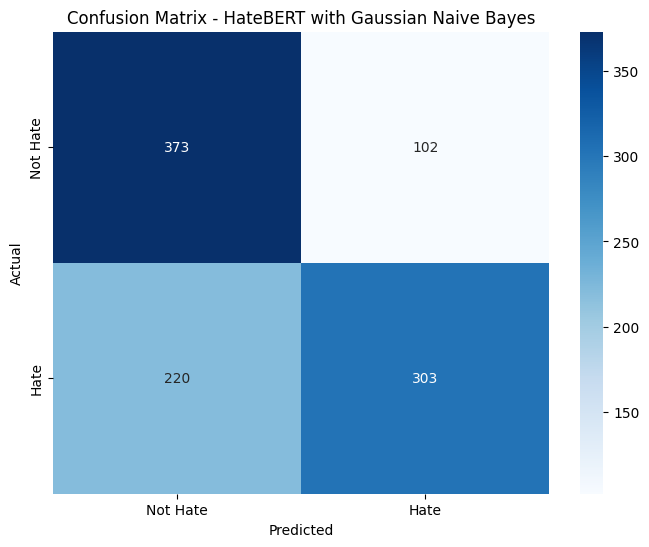

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Hate', 'Hate'],
            yticklabels=['Not Hate', 'Hate'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - HateBERT with Gaussian Naive Bayes')
plt.show()

In [ ]:
def predict_hate_speech(text, threshold=0.5):
    embedding = get_hatebert_embeddings([text])
    
    proba = nb_classifier.predict_proba(embedding)[0]
    prediction = 1 if proba[1] >= threshold else 0
    label_name = "Hate Speech" if prediction == 1 else "Not Hate Speech"
    
    return {
        "text": text,
        "prediction": prediction,
        "label_name": label_name,
        "confidence": proba[prediction],
        "hate_probability": proba[1]
    }

In [ ]:
import pickle

with open('hatebert_nb_model.pkl', 'wb') as f:
    pickle.dump(nb_classifier, f)

print("Model saved as 'hatebert_nb_model.pkl'")

Model saved as 'hatebert_nb_model.pkl'
